In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [13]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [14]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [15]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [16]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [17]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [18]:
inspector = inspect(engine)
cols = inspector.get_columns('Measurement')
for col in cols:
    print(col['name'], col['type'])
    
print("-----------------------------")
cols = inspector.get_columns('Station')
for col in cols:
    print(col['name'], col['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [84]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
#     start_date = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
#     end_date = dt.datetime.strptime(end_date, "%Y-%m-%d").date()
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [153]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
startdate = dt.datetime.strptime('2017-08-01', "%Y-%m-%d").date()-dt.timedelta(days=365)
enddate = dt.datetime.strptime("2017-08-07", "%Y-%m-%d").date()-dt.timedelta(days=365)

temps = calc_temps(startdate, enddate)
print("Previous year temprature calculations: ")
print("Min temperature: ", temps[0][0])
print("Max temperature: ", temps[0][2])
print("Average temperature: ", temps[0][1])

Previous year temprature calculations: 
Min temperature:  72.0
Max temperature:  83.0
Average temperature:  77.79545454545455


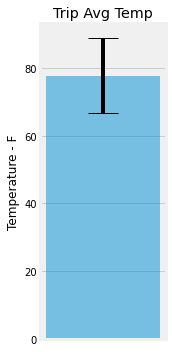

In [154]:
# Plot the results from your previous query as a bar chart.
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# Build the plot
y = temps[0][2]-temps[0][0]
x_pos = len(temps)
fig, ax = plt.subplots(figsize=(2.5, 5))
ax.bar(x_pos, temps[0][1], yerr=y, align='center', alpha=0.5, ecolor='black', capsize=15)
ax.set_ylabel('Temperature - F')
ax.set_xticks(range(x_pos))
ax.set_title('Trip Avg Temp')

# Save the figure and show
plt.tight_layout()
plt.savefig('Images/error_bar_plot.png')

### Daily Rainfall Average

In [155]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
rainfall1 = session.query(Measurement.station, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= startdate).\
            filter(Measurement.date <= enddate).group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()

# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall_df = pd.DataFrame(rainfall, columns = ["Station", "Rainfall", "Lat", "Lng", "Elevation"])
rainfall_df

,Station,Rainfall,Lat,Lng,Elevation
0,USC00516128,0.36,21.33310,-157.80250,152.4
1,USC00514830,0.22,21.52130,-157.83740,7.0
2,USC00519281,0.06,21.45167,-157.84889,32.9
3,USC00519397,0.04,21.27160,-157.81680,3.0
4,USC00519523,0.00,21.33556,-157.71139,19.5


In [156]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [187]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates

mydates = pd.date_range(startdate, enddate)
mydates

# Strip off the year and save a list of strings in the format %m-%d
normals = []
for date in mydates:
    day_month = dt.datetime.strftime(date, "%m-%d")
    # Use the `daily_normals` function to calculate the normals for each date string 
    #and append the results to a list called `normals`.
    normals.append(daily_normals(day_month)[0])
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [180]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(normals, columns = ["temp_min", "temp_avg", "temp_avg"])
daily_normals_df['date'] = mydates
daily_normals_df

,temp_min,temp_avg,temp_avg,date
0,67.0,75.540000,83.0,2016-08-01
1,68.0,75.603774,84.0,2016-08-02
2,70.0,76.611111,85.0,2016-08-03
3,69.0,76.711538,84.0,2016-08-04
4,69.0,76.148148,82.0,2016-08-05
5,67.0,76.250000,83.0,2016-08-06
6,71.0,77.156863,83.0,2016-08-07


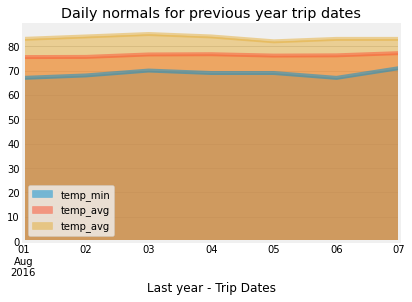

In [185]:
# Plot the daily normals as an area plot with `stacked=False`

daily_normals_df.plot.area(stacked=False, x='date', title='Daily normals for previous year trip dates', xlabel ='Last year - Trip Dates',)
plt.savefig('Images/area_plot.png')

## Close Session

In [ ]:
session.close()